# Table of Contents:

- [Importing Libraries and Data](#Importing)


- [Data Exploration:](#Exploration)
    - [Checking Normal Distribution of Data](#distribution-check)
    - Describe shape, describe, etc.....
    - [Summary of Findings](#exploration-summary)
    
    
- [Data Cleaning:](#Cleaning)
    - [Checking for Duplicates:](#duplicates) 
    - [Coverting Datatypes:](#Converting-Datatypes)
        - [Date to Datetime Format](#convert_datetime)
    - [Dealing With Missing and Extraneous Values:](#Missing) 
       - ['yr_renovated'](#cleaning_yr_renovated)
       - ['sqft_basement'](#cleaning_sqft_basement)
    - [Dummy Coding Categorical Variables:](#Dummy-Coding)
        - ['Zip Code'](#Dummy-Zip)
        - ['Waterfront'](#dummy_waterfront)


- [Model Decisions:](#model-decisions) 
    - [Correlation Matrices](#corr-matrices) 
    - [Checking for Linear Assumptions:](#linear-assumption) 
  

- [Training and Testing Our MultiLinear Regression Model:](#train-test-mlr)
    - [Model 1](#model-1)
    - [Model 2](#model-2) 


- [Summary of Findings:](#conclusion)
    

<a id="Importing"></a>
# Importing Libraries and Data:

In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix # data processing, scatter matrix 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
from sklearn.preprocessing import StandardScaler as scaler

import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('kc_house_data.csv')
# df = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/dsc-v2-mod1-final-project-dc-ds-career-042219/master/kc_house_data.csv')

# Functions

In [2]:
#Plotting
def plot_hist(x_variable, df):
    print("Skewness: %f" % df[x_variable].skew())
    print("Kurtosis: %f" % df[x_variable].kurt())
    sns.set(rc={'figure.figsize':(12,8)})
    sns.distplot(df[x_variable], bins=20);

def plot_scatter(x_variable, df):
    sns.lmplot(x=x_variable, y="price", data=df);
    
def plot_bar(x_variable, df):
    print("Skewness: %f" % df[x_variable].skew())
    print("Kurtosis: %f" % df[x_variable].kurt())
    sns.barplot(x=x_variable, y='price', data=df);
    
def plot_count(x_variable, df):
    sns.countplot(x=x_variable, data=df)

#can add input command to set viarbales, but make sure change type as appropriate

<a id="Exploration"></a>
# Initial Data Exploration:

<a id="exploration-summary"></a>
## Summary of Initial Data Exploration:

#### Distribution:

* Histogram of 'price' shows only a few outliers beyond $1 Million. 
    * Accounts for only 6.75% of dataset, 
    * Decision to drop these outliers from final dataset, used by our model
* 'Bedrooms' has an unlikely maximum of 33 units.  
* 'sqft_lot' has an unlikely maximum of 1.65 Million sqft
* 'yr_renovated' seems to have limited data


#### Wrongly Formatted:
* 'sqft_basement' needs to be in integer or float format
* 'date' needs to be in datetime format

#### NaN Values
* 'waterfront', 'view' and 'yr_renovated' have NaN values

#### Duplicate Entries
* The properties that were entered twice have been kept in
    * No rows are exactly the same, majority are 6 month turnaround with jump in price
    * Our best guess is the first entry was an undervaluation caused by foreclosure
    * Keeping both entries will average out each other

#### Ambiguous Columns: 
- waterfront = if the property has a view to the waterfront
- view = "has been viewed" (scale of 0-4, predominately 0)
- condition = overall state of condition (1-5 = poor-very good)
- grade = Represents the construction quality of improvements. Grades run from grade 1 to 13.
- sqft_living15/lot15 = sqft of living/lot area of 15 closest neighbors

https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r

In [3]:
df_cleaned = df

In [4]:
df.shape

(21597, 21)

In [5]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [6]:
df.head().T

,0,1,2,3,4
id,7129300520,6414100192,5631500400,2487200875,1954400510
date,10/13/2014,12/9/2014,2/25/2015,12/9/2014,2/18/2015
price,221900,538000,180000,604000,510000
bedrooms,3,3,2,4,3
bathrooms,1,2.25,1,3,2
sqft_living,1180,2570,770,1960,1680
sqft_lot,5650,7242,10000,5000,8080
floors,1,2,1,1,1
waterfront,NaN,0,0,0,0
view,0,0,0,0,0


In [7]:
df.describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
id,21597.0,4.580474e+09,2.876736e+09,1000102.00,2.123049e+09,3.904930e+09,7.308900e+09,9.900000e+09
price,21597.0,5.402966e+05,3.673681e+05,78000.00,3.220000e+05,4.500000e+05,6.450000e+05,7.700000e+06
bedrooms,21597.0,3.370000e+00,9.300000e-01,1.00,3.000000e+00,3.000000e+00,4.000000e+00,3.300000e+01
bathrooms,21597.0,2.120000e+00,7.700000e-01,0.50,1.750000e+00,2.250000e+00,2.500000e+00,8.000000e+00
sqft_living,21597.0,2.080320e+03,9.181100e+02,370.00,1.430000e+03,1.910000e+03,2.550000e+03,1.354000e+04
sqft_lot,21597.0,1.509941e+04,4.141264e+04,520.00,5.040000e+03,7.618000e+03,1.068500e+04,1.651359e+06
floors,21597.0,1.490000e+00,5.400000e-01,1.00,1.000000e+00,1.500000e+00,2.000000e+00,3.500000e+00
waterfront,19221.0,1.000000e-02,9.000000e-02,0.00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
view,21534.0,2.300000e-01,7.700000e-01,0.00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
condition,21597.0,3.410000e+00,6.500000e-01,1.00,3.000000e+00,3.000000e+00,4.000000e+00,5.000000e+00


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


## Dealing with NaN values

<a id="cleaning_sqft_basement"></a>
### Replacing Nan and Extraneous Values in 'sqft_basement':

In [9]:
df_cleaned['sqft_basement_calc'] = df_cleaned['sqft_living']-df_cleaned['sqft_above']
df_cleaned[['sqft_basement', 'sqft_basement_calc']]

,sqft_basement,sqft_basement_calc
0,0.0,0
1,400.0,400
2,0.0,0
3,910.0,910
4,0.0,0
5,1530.0,1530
6,?,0
7,0.0,0
8,730.0,730
9,0.0,0


<a id="Missing"></a>
## Checking for Missing and Extraneous Values:

In [10]:
df.isna().sum().sum()
#Check first if there is any na values.  we find that there's 6281 na values

6281

In [11]:
df.isna().sum().sort_values(ascending=False)
#We can see from this that the columns for yr_renovated and waterfront have a lot of na values.  view only has some

yr_renovated          3842
waterfront            2376
view                    63
sqft_basement_calc       0
date                     0
price                    0
bedrooms                 0
bathrooms                0
sqft_living              0
sqft_lot                 0
floors                   0
condition                0
sqft_lot15               0
grade                    0
sqft_above               0
sqft_basement            0
yr_built                 0
zipcode                  0
lat                      0
long                     0
sqft_living15            0
id                       0
dtype: int64

<a id="duplicates"></a>
## Checking for Duplicates:

In [12]:
df.shape

(21597, 22)

In [13]:
df.nunique().sort_values(ascending=False)

id                    21420
sqft_lot               9776
sqft_lot15             8682
lat                    5033
price                  3622
sqft_living            1034
sqft_above              942
sqft_living15           777
long                    751
date                    372
sqft_basement_calc      306
sqft_basement           304
yr_built                116
yr_renovated             70
zipcode                  70
bathrooms                29
bedrooms                 12
grade                    11
floors                    6
view                      5
condition                 5
waterfront                2
dtype: int64

In [14]:
df[df.duplicated()]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement_calc


### - Duplicates of id

In [15]:
df[df['id'].duplicated(keep = False)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement_calc
93,6021501535,7/25/2014,430000.0,3,1.50,1580,5000,1.0,0.0,0.0,...,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500,290
94,6021501535,12/23/2014,700000.0,3,1.50,1580,5000,1.0,0.0,0.0,...,1290,290.0,1939,0.0,98117,47.6870,-122.386,1570,4500,290
313,4139480200,6/18/2014,1380000.0,4,3.25,4290,12103,1.0,0.0,3.0,...,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,1600
314,4139480200,12/9/2014,1400000.0,4,3.25,4290,12103,1.0,0.0,3.0,...,2690,1600.0,1997,0.0,98006,47.5503,-122.102,3860,11244,1600
324,7520000520,9/5/2014,232000.0,2,1.00,1240,12092,1.0,NaN,0.0,...,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460,280
325,7520000520,3/11/2015,240500.0,2,1.00,1240,12092,1.0,0.0,0.0,...,960,280.0,1922,1984.0,98146,47.4957,-122.352,1820,7460,280
345,3969300030,7/23/2014,165000.0,4,1.00,1000,7134,1.0,0.0,0.0,...,1000,0.0,1943,0.0,98178,47.4897,-122.240,1020,7138,0
346,3969300030,12/29/2014,239900.0,4,1.00,1000,7134,1.0,0.0,0.0,...,1000,0.0,1943,NaN,98178,47.4897,-122.240,1020,7138,0
371,2231500030,10/1/2014,315000.0,4,2.25,2180,10754,1.0,NaN,0.0,...,1100,1080.0,1954,0.0,98133,47.7711,-122.341,1810,6929,1080
372,2231500030,3/24/2015,530000.0,4,2.25,2180,10754,1.0,0.0,0.0,...,1100,1080.0,1954,0.0,98133,47.7711,-122.341,1810,6929,1080


In [16]:
df[df['id'].duplicated()].shape

(177, 22)

## Distributions

### - Distribution of Price

In [17]:
# % of houses above the threshold
cut_off_price = 1000000
(len(df[df['price']>cut_off_price]))/(len(df['price']))*100

6.750937630226421

Skewness: 4.023365
Kurtosis: 34.541359


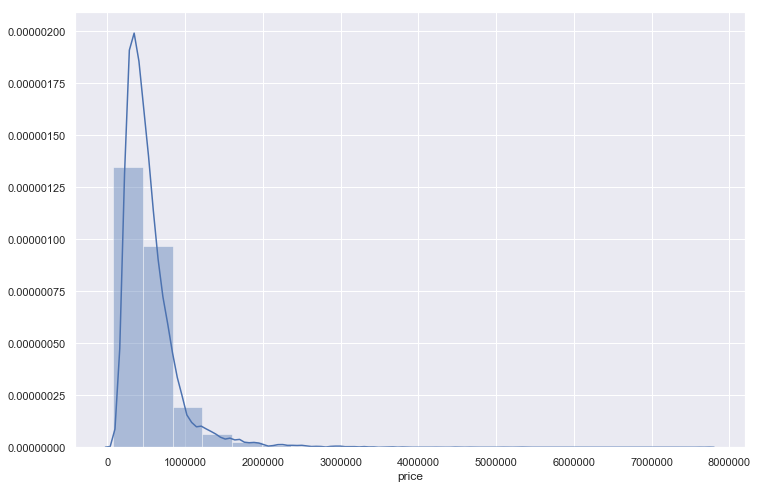

In [18]:
plot_hist('price', df)

Some observations made from drawing the histogram above and fitting the normal distribution to it:

1) The price histogram data deviates from the normal distirbution only slightly, 

2) Has moderate positive skewness.

3) Demonstrates peakedness.

4) Kurtosis of Raw Data is leptokurtic

### - Distribution across all variables

In [20]:
df_cleaned.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_basement_calc'],
      dtype='object')

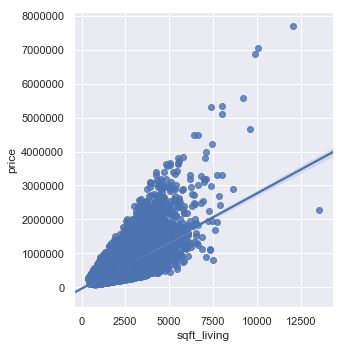

In [21]:
sns.lmplot(x="sqft_living", y="price", data=df_cleaned, palette='Set3');

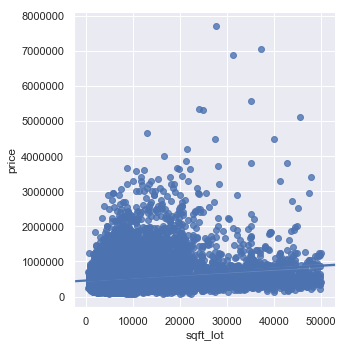

In [22]:
sns.lmplot(x="sqft_lot", y="price", data=df_cleaned[df_cleaned['sqft_lot']<50000]);

In [23]:
temp_df = df_cleaned[df_cleaned['sqft_lot']<20000]
len(temp_df)

19279

Skewness: 13.072604
Kurtosis: 285.495812


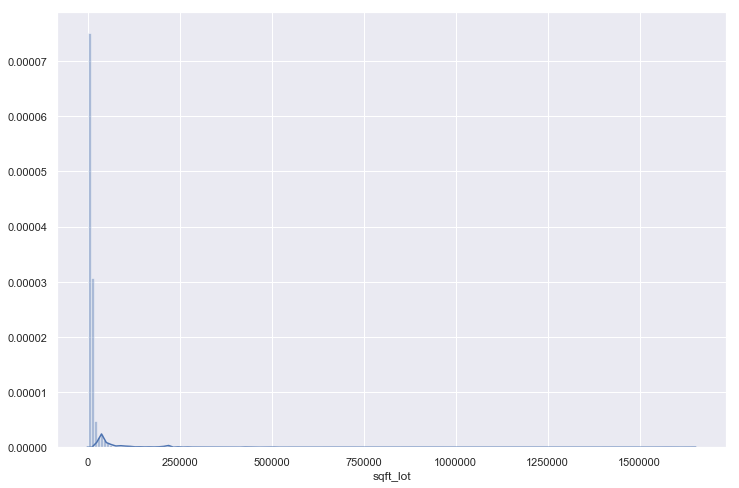

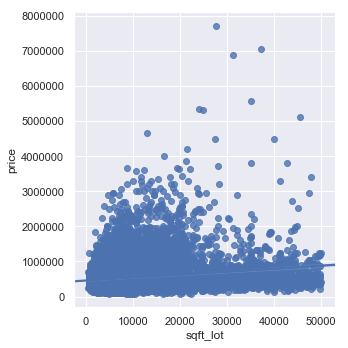

In [24]:
#sqft_lot
sns.distplot(df_cleaned['sqft_lot'], bins=200);
print("Skewness: %f" % df_cleaned['sqft_lot'].skew())
print("Kurtosis: %f" % df_cleaned['sqft_lot'].kurt())

sns.lmplot(x="sqft_lot", y="price", data=df_cleaned[df_cleaned['sqft_lot']<50000]);

In [25]:
df_cleaned.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement_calc
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650,0
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639,400


Skewness: 1.473215
Kurtosis: 5.252102


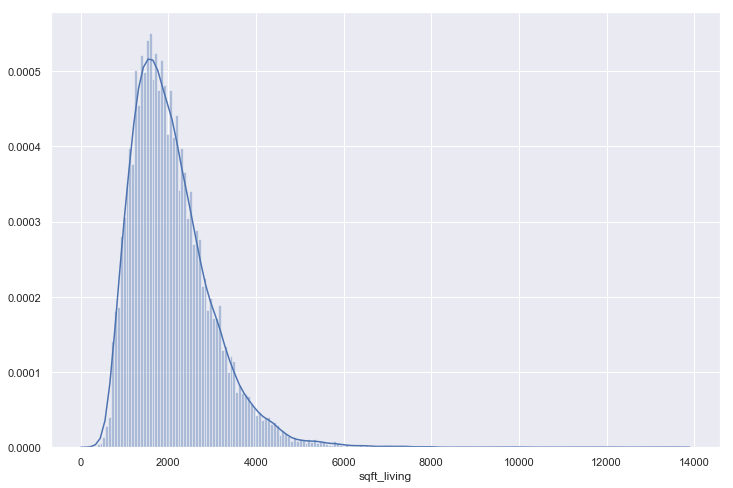

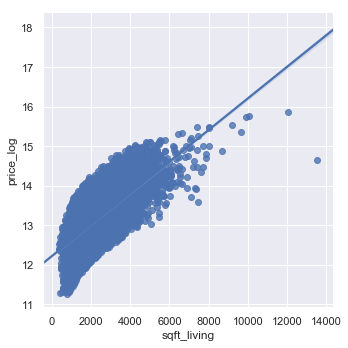

In [26]:
# sqft_living vs price_log
df_cleaned['price_log'] = np.log(df_cleaned['price'])


print("Skewness: %f" % df_cleaned['sqft_living'].skew())
print("Kurtosis: %f" % df_cleaned['sqft_living'].kurt())

sns.distplot(df_cleaned['sqft_living'], bins=200);

sns.lmplot(x="sqft_living", y="price_log", data=df_cleaned);

In [27]:
# sqft_living log
# df_cleaned['sqft_living_log'] = np.log(df_cleaned['sqft_living'])
# hist_and_scatter('sqft_living_log')

Skewness: 0.788237
Kurtosis: 1.135148


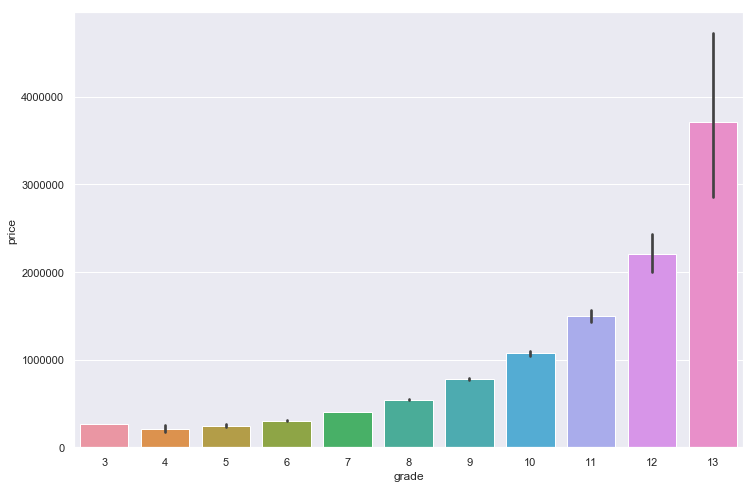

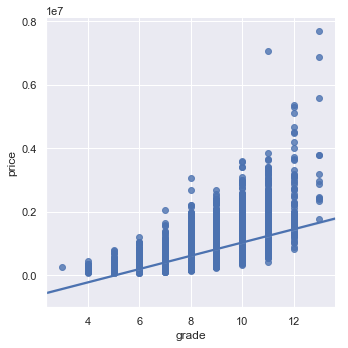

In [28]:
# grade
sns.barplot(x='grade', y='price', data=df_cleaned);
print("Skewness: %f" % df_cleaned['grade'].skew())
print("Kurtosis: %f" % df_cleaned['grade'].kurt())

sns.lmplot(x="grade", y="price", data=df_cleaned);

In [29]:
# #sqft_basement_calc
# sns.distplot(df_cleaned['sqft_basement_calc'], bins=20);
# print("Skewness: %f" % df_cleaned['sqft_basement_calc'].skew())
# print("Kurtosis: %f" % df_cleaned['sqft_basement_calc'].kurt())

# sns.lmplot(x="sqft_basement_calc", y="price", data=df_cleaned);

In [30]:
# # sqft_basement_calc (those that have a basement)
# df_have_basement = df_cleaned[df_cleaned['sqft_basement_calc']>0]

# print("Skewness: %f" % df_have_basement['sqft_basement_calc'].skew())
# print("Kurtosis: %f" % df_have_basement['sqft_basement_calc'].kurt())

# sns.distplot(df_have_basement['sqft_basement_calc'], bins=50);

# sns.lmplot(x="sqft_basement_calc", y="price", data=df_have_basement);

Skewness: 0.614497
Kurtosis: -0.491066
Skewness: 0.614497
Kurtosis: -0.491066


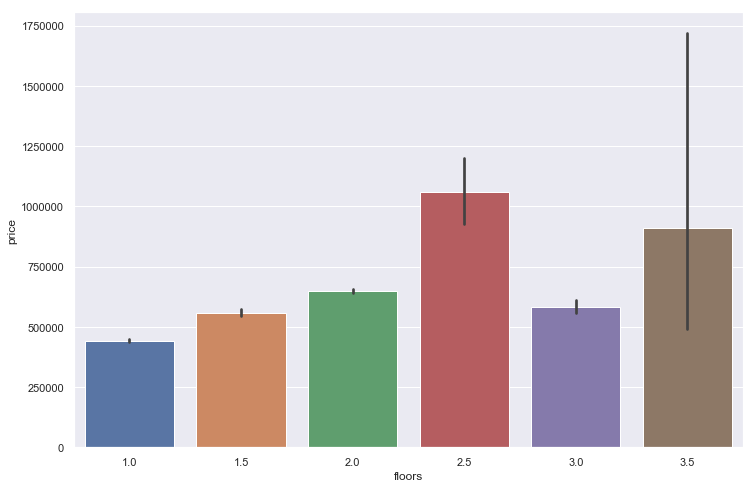

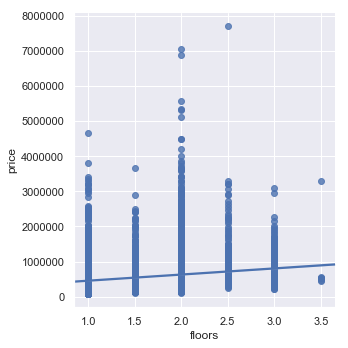

In [31]:
#floors
print("Skewness: %f" % df_cleaned['floors'].skew())
print("Kurtosis: %f" % df_cleaned['floors'].kurt())
plot_bar('floors', df_cleaned)
plot_scatter('floors', df_cleaned)

Skewness: 0.531349
Kurtosis: 1.769421


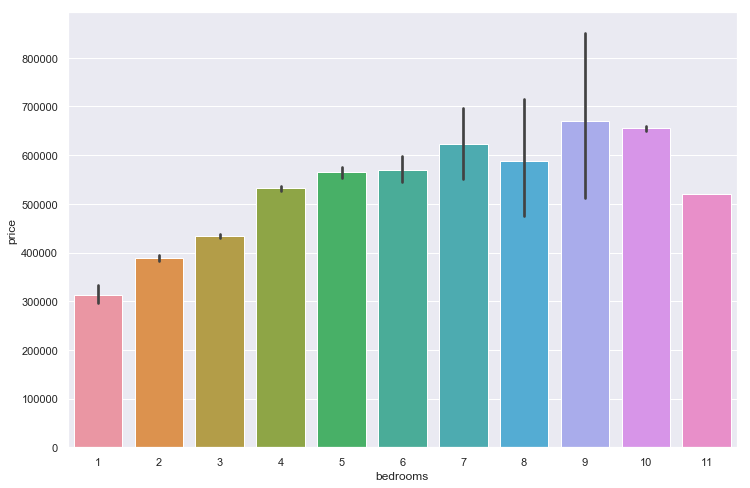

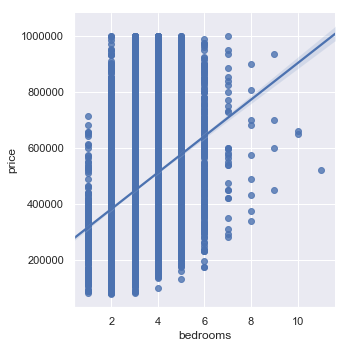

In [74]:
#bedrooms
plot_bar('bedrooms', df_cleaned)
plot_scatter('bedrooms', df_cleaned)

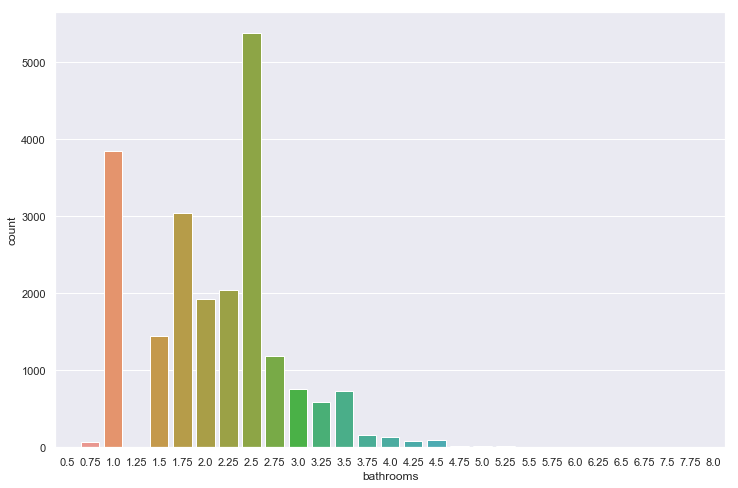

In [33]:
#bathrooms
plot_count('bathrooms', df_cleaned)

Skewness: 0.519709
Kurtosis: 1.279315


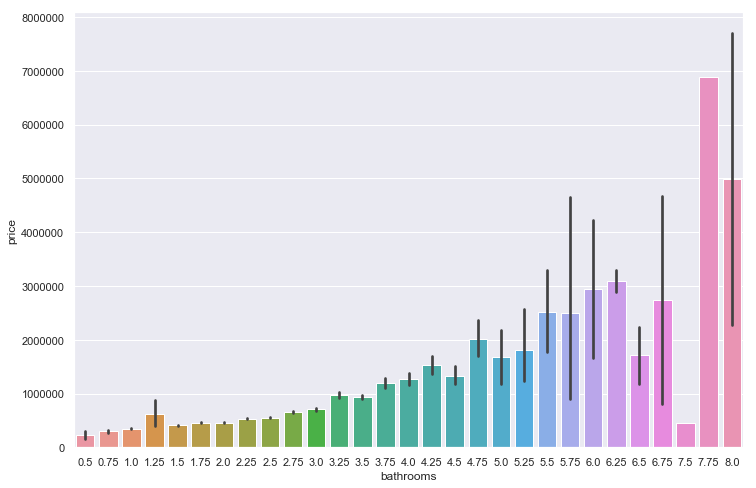

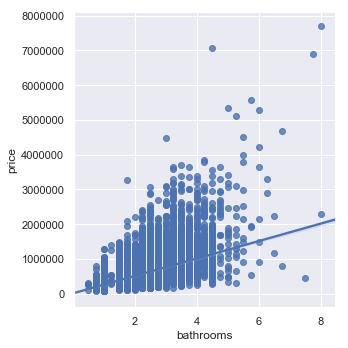

In [34]:
#bathrooms
plot_bar('bathrooms', df_cleaned)
plot_scatter('bathrooms', df_cleaned)


Skewness: 4.573385
Kurtosis: 18.919543


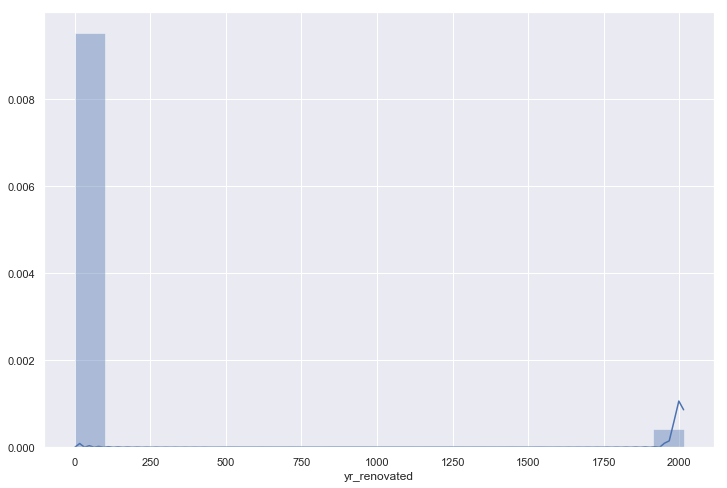

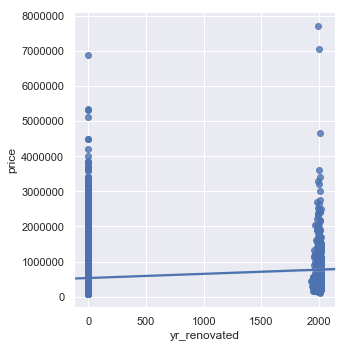

In [35]:
# yr_renovated
# can we just show those that are not 0?
plot_hist('yr_renovated', df_cleaned)
plot_scatter('yr_renovated', df_cleaned)

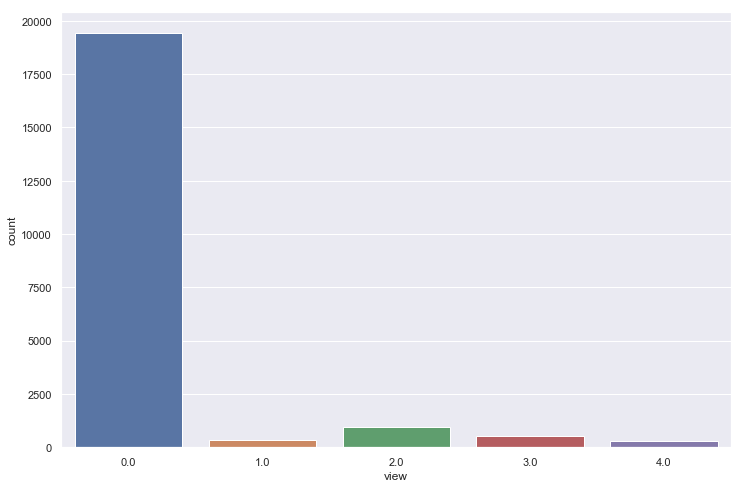

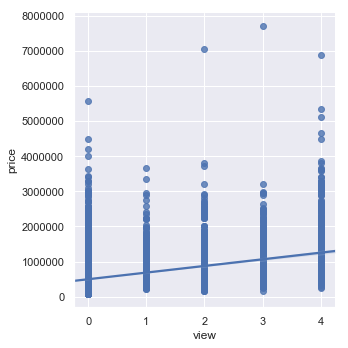

In [36]:
#view
plot_count('view', df_cleaned)
plot_scatter('view', df_cleaned)

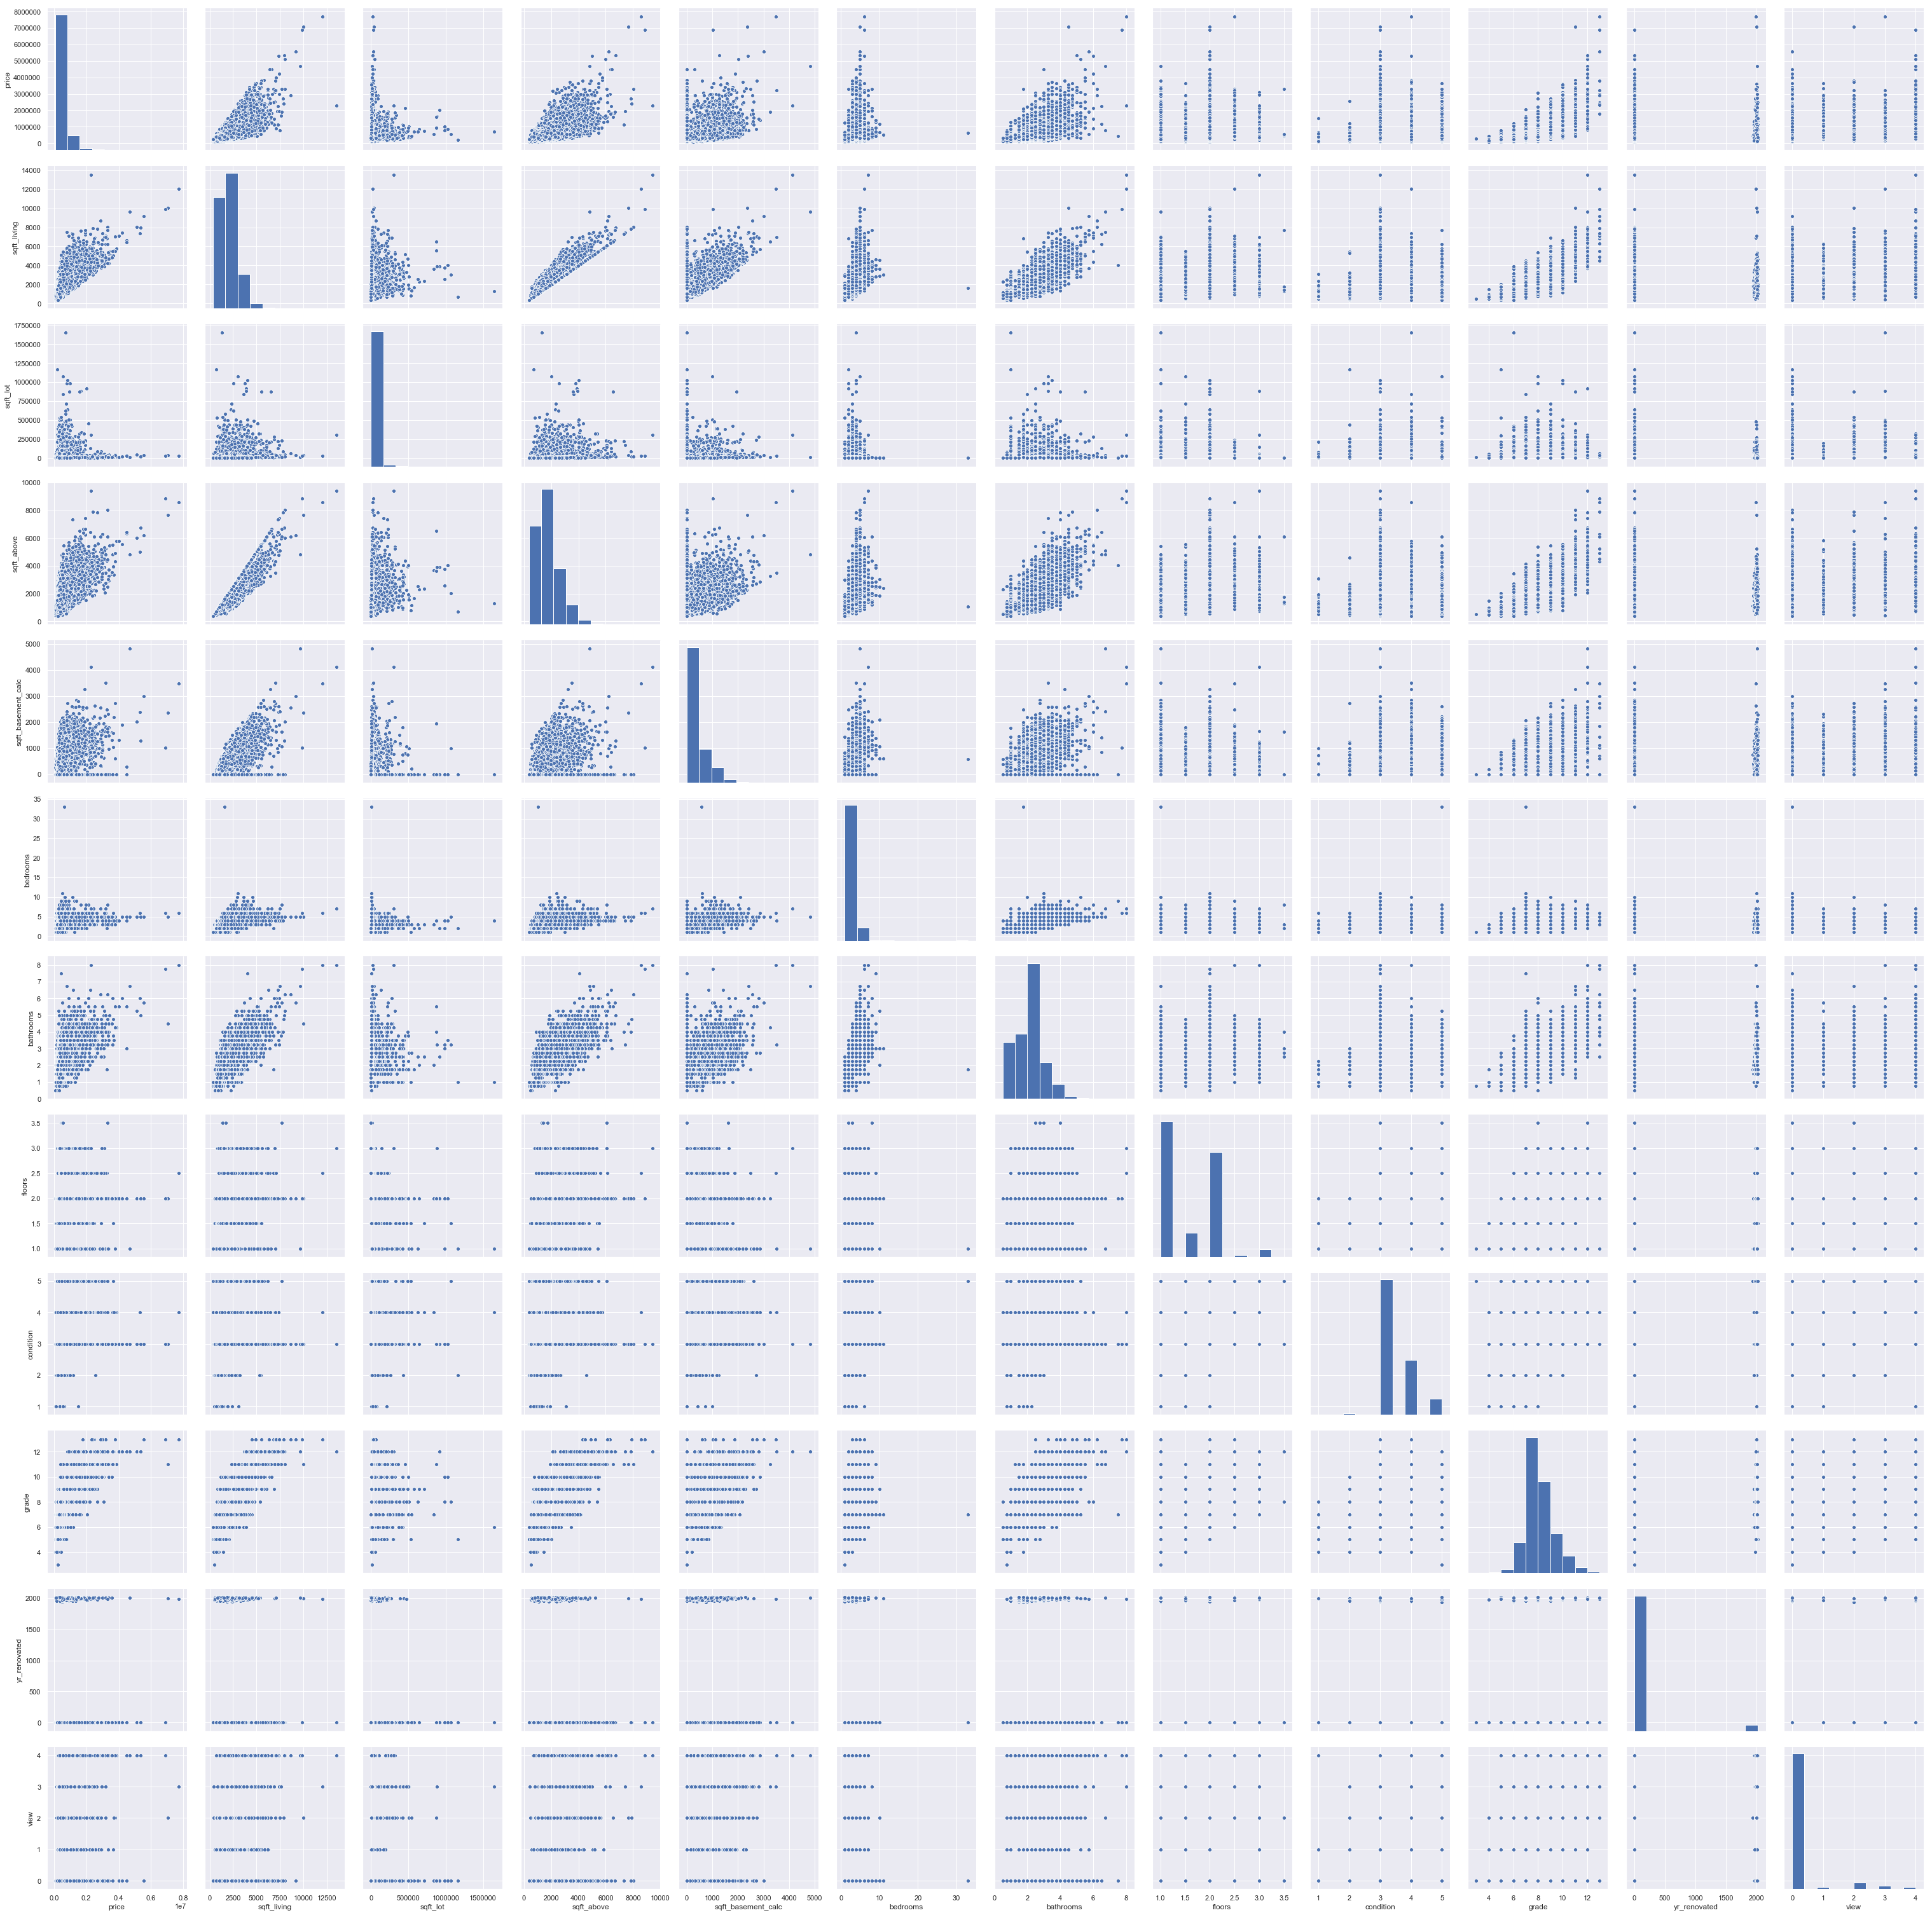

In [37]:
#plot matrix
sns.set()
cols = ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement_calc', 'bedrooms', 'bathrooms', 'floors', 'condition', 'grade', 'yr_renovated', 'view']
sns.pairplot(df_cleaned[cols], size = 3.5)
plt.show();

<a id="Cleaning"></a>
# Data Cleaning:

## Summary of Data Cleaning:
* Dropped houses in dataset that were over $1M
* Droppped an extreme 'bedrooms' value's row
* Dummy coded 'waterfront' into 3 variables
* 'yr_renovated' column as very little useful data

## Dropping Data

### - Dropping Price Outliers

In [38]:
df_cleaned = df_cleaned[df_cleaned['price']<cut_off_price]

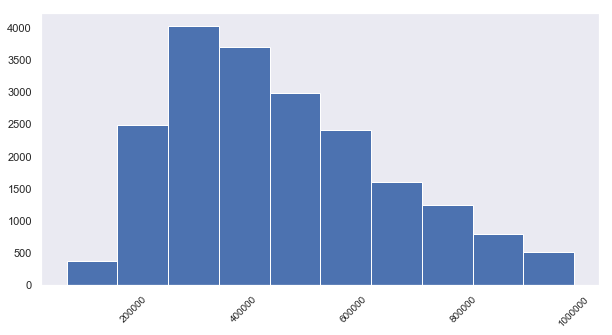

In [39]:
df_cleaned['price'].hist(xlabelsize=10, xrot=45, figsize=(10,5), grid=False, bins=10);

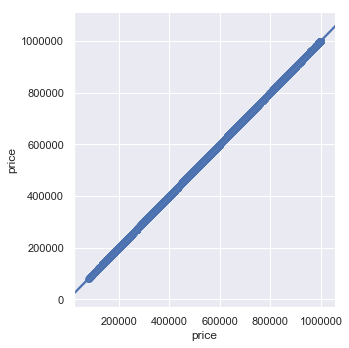

In [40]:
sns.lmplot(x='price', y='price', data=df_cleaned);

### - Dropping Extreme Bedrooms Value

In [41]:
df_cleaned = df_cleaned[df_cleaned['bedrooms']<33]

In [42]:
df_cleaned['bedrooms'].max()

11

<a id="cleaning_yr_renovated"></a>
### - Dropping 'yr_renovated' due to lack of bad data:

In [43]:
df_cleaned['yr_renovated'].value_counts(normalize=True).head()

0.0       0.963836
2014.0    0.003810
2013.0    0.001633
2000.0    0.001512
2007.0    0.001391
Name: yr_renovated, dtype: float64

In [44]:
df_cleaned['yr_renovated'].isna().sum()

3570


###### We can see from this that almost 96% of values in this column are '0'.  This column therefore doesn't offer much value
###### This is in addition to the NA values shown before
###### We can assume its bad data as when we look at duplicates and "quick rennovation" idea, the yr_renovated column is often == 0


<a id="Dummy-Coding"></a>
## Dummy-Coding Categorical Variables:

### - Waterfront

In [45]:
df_cleaned['waterfront'].value_counts()

0.0    17830
1.0       49
Name: waterfront, dtype: int64

In [46]:
# replaced the NaN values in 'waterfront' with the value 2.
df_cleaned['waterfront'] = df_cleaned['waterfront'].replace(np.nan,2)

In [47]:
#df_cleaned up to date til this stage
df_cleaned.shape

(20106, 23)

<a id="Converting-Datatypes"></a>
## Converting Datatypes:

# !!!!!! Don't NEED THIS CONVERSION TO FLOAT AS WE HAVE A NEW COLUMN!!!!!

### Converting 'sqft_basement' to float format:

In [48]:
# df_cleaned['sqft_basement'] = df_cleaned ['sqft_basement'].astype(float)
# type(df_cleaned['sqft_basement'][1])

<a id="datetime"></a>
### Converting 'date' to datetime format:

In [49]:
#converted the 'date' column from object to datetime format
pd.to_datetime(df_cleaned['date'], format="%m/%d/%Y").head(3)


0   2014-10-13
1   2014-12-09
2   2015-02-25
Name: date, dtype: datetime64[ns]

# Further Data Exploration

<a id="exploration-summary"></a>
## Summary of Further Data Exploration:

* 

Controllable: factors which homeowners conceivably have the opportunity to improve upon
* Size: sqft_basement, sqft_above, sqft_living, sqft_lot
* Amenities: bathrooms, bedrooms, floors
* Upkeep: grade, condition, yr_renovated

## Data Distribution

In [50]:
# df_cleaned['sqft_lot_yes'] = df_cleaned[df_cleaned['sqft_lot'>0]]

In [51]:
df_cleaned[df_cleaned['sqft_lot']<100000].describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_basement_calc,price_log
count,1.969600e+04,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000,19641.000000,19696.000000,...,19696.000000,19696.000000,16177.000000,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000,19696.000000
mean,4.661518e+09,464985.432474,3.320370,2.033027,1941.660337,10025.532037,1.470146,0.224056,0.155949,3.406478,...,1679.021527,1970.570979,71.297707,98079.314734,47.557511,-122.216850,1899.407545,9781.611799,262.638810,12.959314
std,2.875517e+09,195158.187946,0.883244,0.700669,745.546622,11137.117209,0.537308,0.628923,0.606706,0.645556,...,701.816821,29.188511,370.414967,53.491177,0.140689,0.139689,598.295457,13616.717058,401.894436,0.434101
min,1.000102e+06,78000.000000,1.000000,0.500000,370.000000,520.000000,1.000000,0.000000,0.000000,1.000000,...,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.512000,399.000000,651.000000,0.000000,11.264464
25%,2.206500e+09,311000.000000,3.000000,1.500000,1390.000000,5000.000000,1.000000,0.000000,0.000000,3.000000,...,1160.000000,1951.000000,0.000000,98033.000000,47.461900,-122.331000,1460.000000,5000.000000,0.000000,12.647548
50%,4.022900e+09,430000.000000,3.000000,2.000000,1830.000000,7416.000000,1.000000,0.000000,0.000000,3.000000,...,1500.000000,1974.000000,0.000000,98070.000000,47.566900,-122.239000,1780.000000,7500.000000,0.000000,12.971540
75%,7.421175e+09,589999.250000,4.000000,2.500000,2390.000000,10013.250000,2.000000,0.000000,0.000000,4.000000,...,2060.000000,1996.000000,0.000000,98118.000000,47.680525,-122.128000,2240.000000,9680.000000,500.000000,13.287877
max,9.900000e+09,999999.000000,11.000000,7.500000,7480.000000,99916.000000,3.500000,2.000000,4.000000,5.000000,...,5710.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,4950.000000,392040.000000,2400.000000,13.815510


In [52]:
df_cleaned[df_cleaned['sqft_lot']>1000].info()
# df[df['price']>cut_off_price]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19903 entries, 0 to 21596
Data columns (total 23 columns):
id                    19903 non-null int64
date                  19903 non-null object
price                 19903 non-null float64
bedrooms              19903 non-null int64
bathrooms             19903 non-null float64
sqft_living           19903 non-null int64
sqft_lot              19903 non-null int64
floors                19903 non-null float64
waterfront            19903 non-null float64
view                  19846 non-null float64
condition             19903 non-null int64
grade                 19903 non-null int64
sqft_above            19903 non-null int64
sqft_basement         19903 non-null object
yr_built              19903 non-null int64
yr_renovated          16371 non-null float64
zipcode               19903 non-null int64
lat                   19903 non-null float64
long                  19903 non-null float64
sqft_living15         19903 non-null int64
sqft_lot15   

In [53]:
#DFs for plotting different controllable groups
df_size = df_cleaned[['sqft_above', 'sqft_lot', 'sqft_living', 'sqft_basement']]
df_amenities = df_cleaned[['bathrooms', 'bedrooms', 'floors']]
df_upkeep = df_cleaned[['grade', 'condition', 'yr_renovated']]

### - Histograms for Size variables

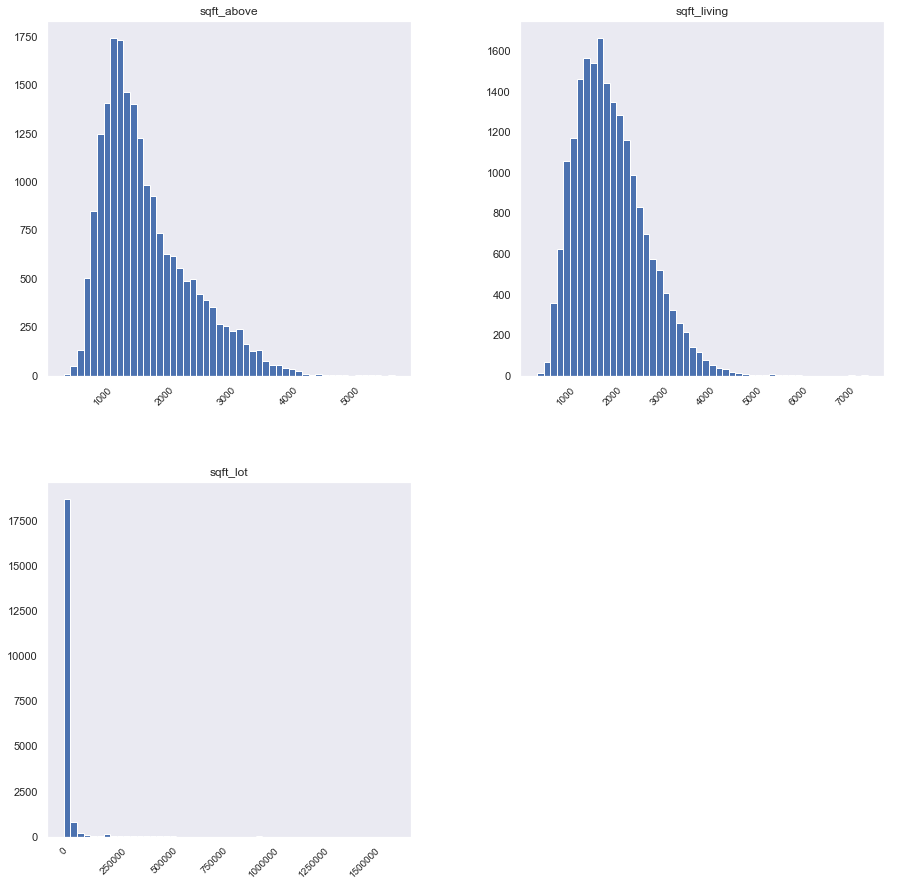

In [54]:
df_size.hist(xlabelsize=10, xrot=45, figsize=(15,15), grid=False, bins=50);

### - Histograms for Amenities variables

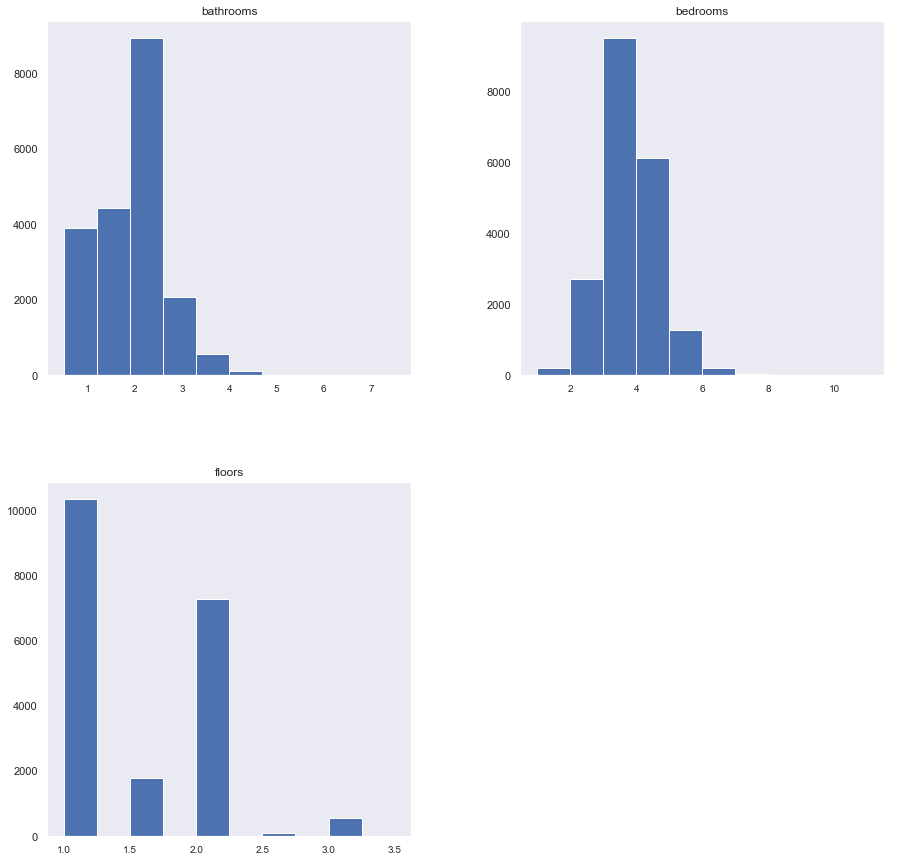

In [55]:
df_amenities.hist(xlabelsize=10, figsize=(15,15), grid=False);

### - Histograms for Upkeep variables

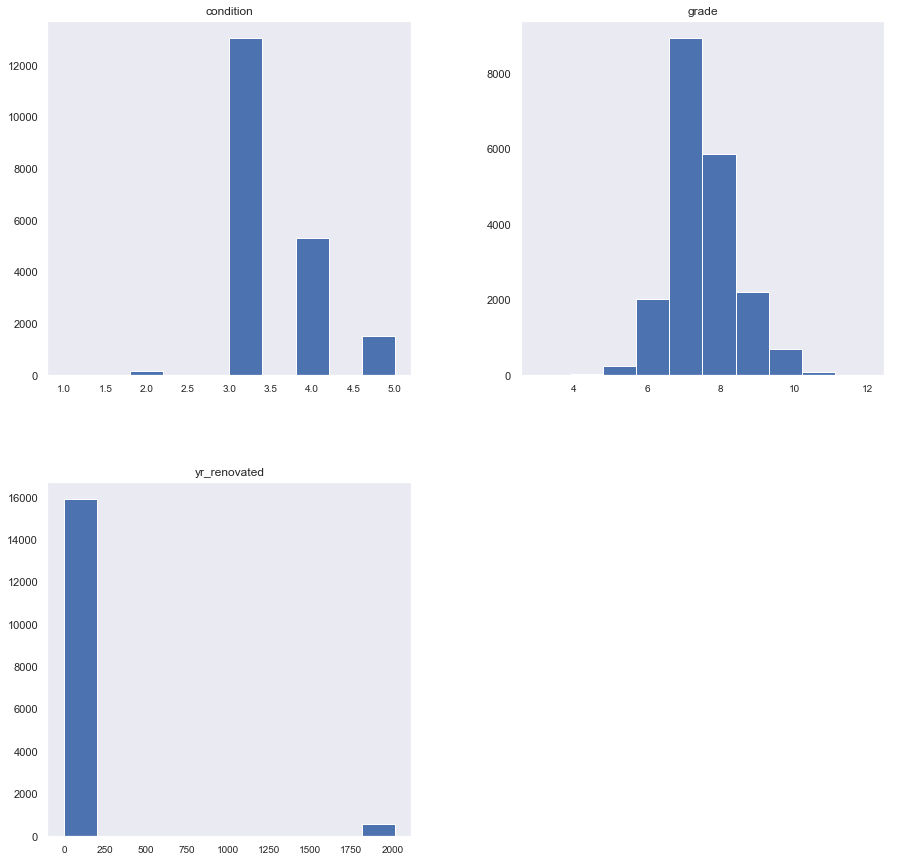

In [56]:
df_upkeep.hist(xlabelsize=10, figsize=(15,15), grid=False);

# Modeling Decisions:

## Checking For Normal Distributions:

## Checking Linear Relationship Assumption:

https://seaborn.pydata.org/tutorial/regression.html#functions-to-draw-linear-regression-models

In [57]:
df_cleaned['has_basement'] = df_cleaned['sqft_basement_calc']>0
df_cleaned['has_basement']

0        False
1         True
2        False
3         True
4        False
6        False
7        False
8         True
9        False
10        True
11        True
12       False
13       False
14       False
15        True
16       False
17       False
18       False
19       False
20        True
22       False
23       False
24       False
25       False
26        True
27       False
28        True
29       False
30       False
31       False
         ...  
21562    False
21563     True
21564    False
21565    False
21566     True
21567    False
21568     True
21569    False
21570    False
21571    False
21572     True
21573    False
21575    False
21576    False
21578    False
21579     True
21580    False
21582    False
21583    False
21585    False
21586    False
21587    False
21588    False
21589    False
21591     True
21592    False
21593    False
21594    False
21595    False
21596    False
Name: has_basement, Length: 20106, dtype: bool

In [58]:
# df_has_basement = df_cleaned[df_cleaned['sqft_basement_calc']>0]
# df_has_basement

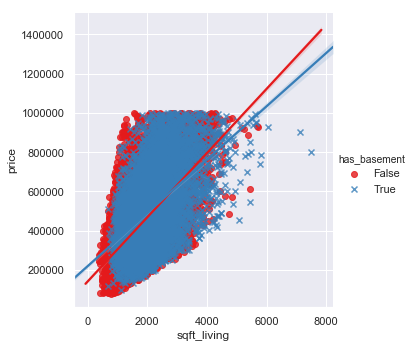

In [59]:
#Shows the sqft_living variation in price.  split into whether has basement or not
sns.lmplot(x="sqft_living", y="price", hue='has_basement', data=df_cleaned, markers=["o", "x"], palette="Set1");

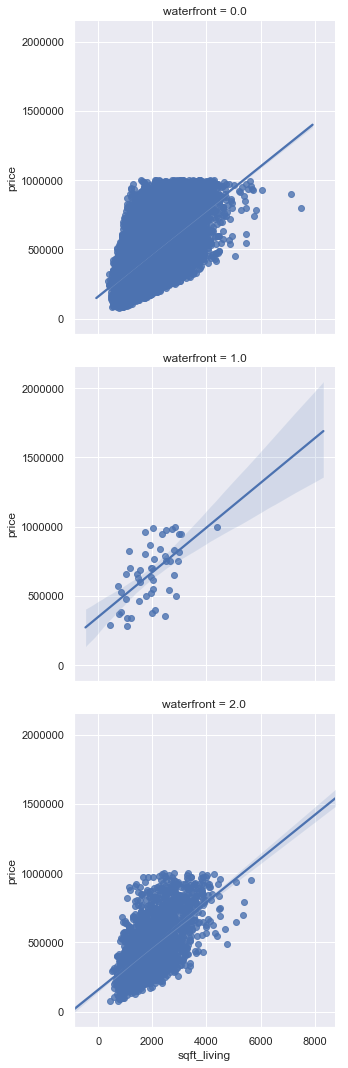

In [60]:
sns.lmplot(x="sqft_living", y="price", row='waterfront', data=df_cleaned, palette="Set1");

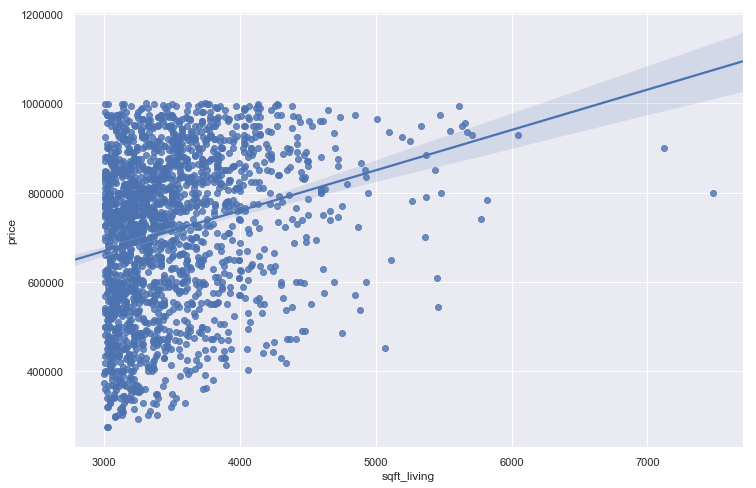

In [61]:
sns.regplot(x="sqft_living", y="price", data=df_cleaned[df_cleaned['sqft_living']>3000]);

In [62]:
df_cleaned['sqft_living'].describe()

count    20106.000000
mean      1954.377450
std        754.852568
min        370.000000
25%       1390.000000
50%       1840.000000
75%       2410.000000
max       7480.000000
Name: sqft_living, dtype: float64

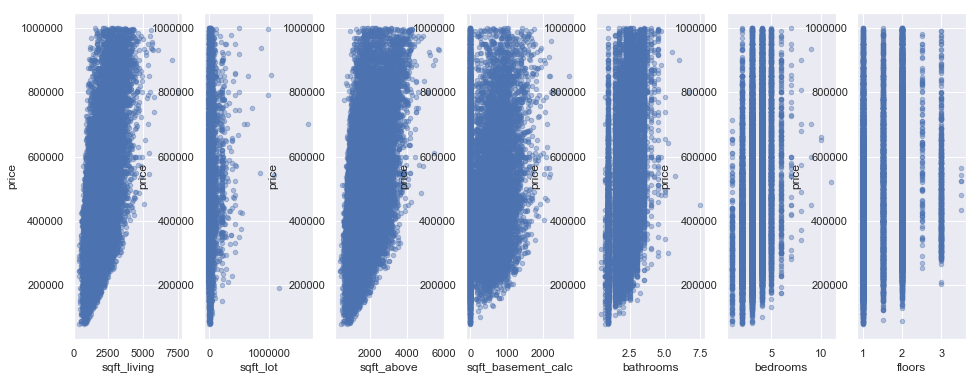

In [63]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(16,6))

for xcol, ax in zip(['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement_calc', 'bathrooms', 'bedrooms','floors'], axes):
    df_cleaned.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')

In [64]:
#see previous comments in categorizing zipcode; decision to use sq_ft_!5 instead
#scatter to see if there's extremes of zipcode vs price
#get the mean price of each property in each zipcode category and plot mean price vs zipcode


## Correlation Matrices:

### Investigating Top Predictors of Price:

In [65]:
#df_cleaned.corr()[['price']].sort_values(by=['price'], ascending=False)
    

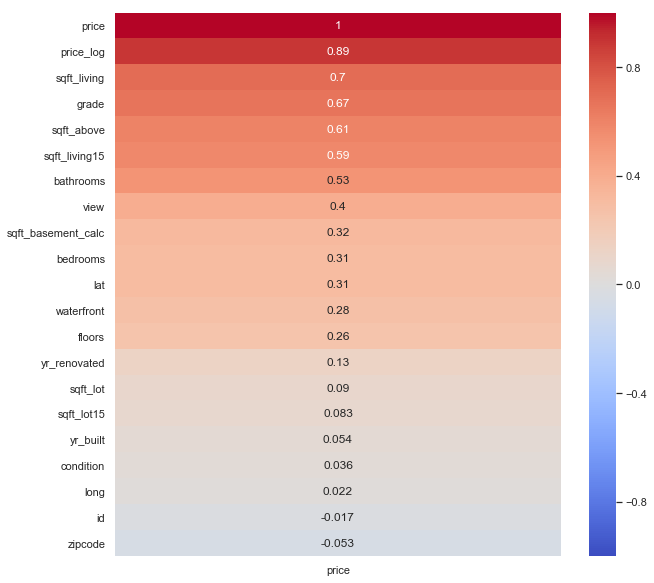

In [66]:
#Plot a heatmap to see where which variables are strongly correlated with target "price"
plt.figure(figsize = (10, 10))
sns.heatmap(df.corr()[['price']].sort_values(by=['price'],ascending=False), vmin = -1, vmax = 1, cmap = 'coolwarm', annot=True)
#from the heatmap below we can see that there are no strong negative correlations, but there are several positive correlations:
#bathrooms, sqft_living, grade, sqft_above, sqft_living15

## Investigating Multicollinearity:

In [67]:
#no correlations above .90 - can assume independence of IVs
#df_cleaned.corr().round(2)


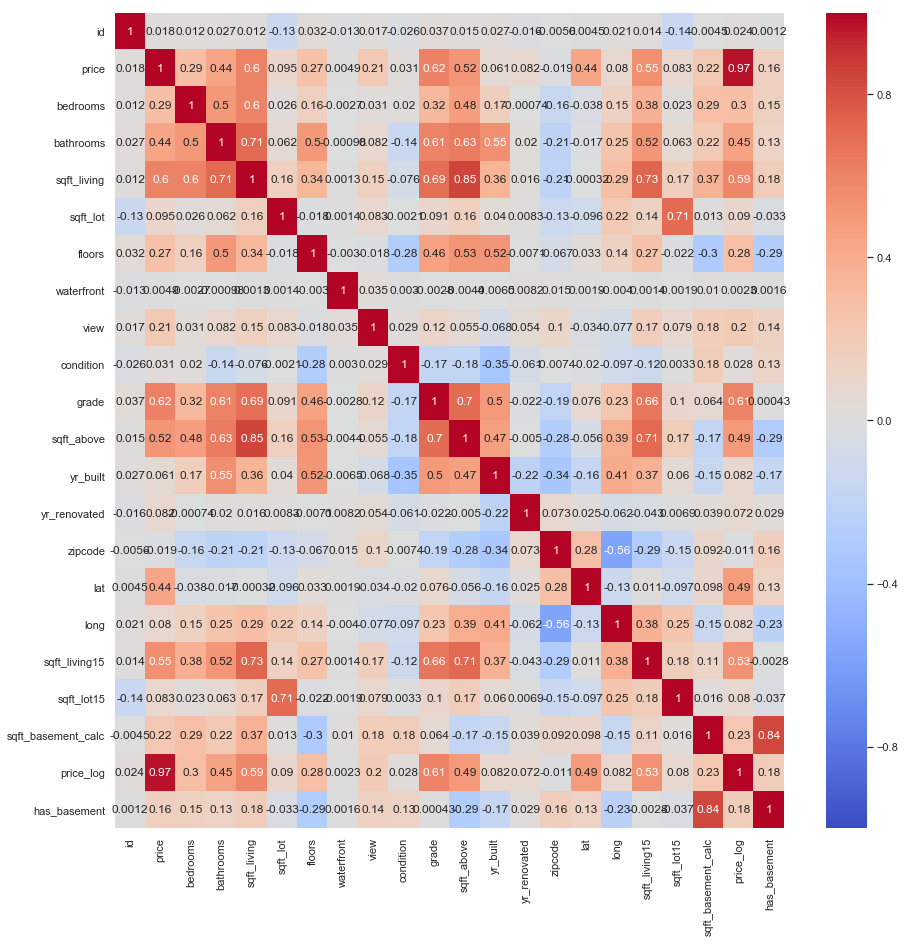

In [68]:
# come back and add a filter for correlation table so zip codes are not displayed
#checking for correlations of .90 or above between IVs 
plt.figure(figsize = (15, 15))
sns.heatmap(df_cleaned.corr(), vmin = -1, vmax = 1, cmap = 'coolwarm', annot = True);


# Standardising the data

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

In [69]:
df_cleaned.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_basement_calc',
       'price_log', 'has_basement'],
      dtype='object')

In [81]:
df_cleaned_std = df_cleaned[['bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_basement_calc',
       'price_log', 'has_basement']]

In [72]:
df_cleaned_model1 = df_cleaned[['price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'condition', 'grade',
       'sqft_above', 'has_basement']].copy()
# 'yr_renovated' hasnt been fixed, so cant add

In [73]:
df_cleaned_model1.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,has_basement
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,False
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,True
2,180000.0,2,1.00,770,10000,1.0,3,6,770,False
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,True
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,False


In [90]:
df_cleaned_std.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15',
       'sqft_basement_calc', 'price_log', 'has_basement'],
      dtype='object')

In [77]:
df_cleaned.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15', 'sqft_basement_calc',
       'price_log', 'has_basement'],
      dtype='object')

In [114]:
# df_cleaned_std.drop(['price'], axis=1, inplace=True)

In [109]:
# df_cleaned_std.drop(['sqft_basement', 'id', 'date'], axis=1, inplace=True)

In [86]:
df_cleaned_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20106 entries, 0 to 21596
Data columns (total 20 columns):
bedrooms              20106 non-null int64
bathrooms             20106 non-null float64
sqft_living           20106 non-null int64
sqft_lot              20106 non-null int64
floors                20106 non-null float64
waterfront            20106 non-null float64
view                  20049 non-null float64
condition             20106 non-null int64
grade                 20106 non-null int64
sqft_above            20106 non-null int64
yr_built              20106 non-null int64
yr_renovated          16536 non-null float64
zipcode               20106 non-null int64
lat                   20106 non-null float64
long                  20106 non-null float64
sqft_living15         20106 non-null int64
sqft_lot15            20106 non-null int64
sqft_basement_calc    20106 non-null int64
price_log             20106 non-null float64
has_basement          20106 non-null bool
dtypes: bool(1),

In [84]:
type(df_cleaned_std)

pandas.core.frame.DataFrame

### (Copying other project)

In [87]:
#standardising by copying other project
from numpy.random import normal
import numpy as np
from scipy.stats import norm
norm.fit(df_cleaned_std.SalePrice)

### Using Kelly's way

In [88]:
# df_cleaned_scaled = scaler(df_cleaned['price'])
# type(df_cleaned_scaled)
data = np.array(df_cleaned_std)
scaled_data = scaler.fit_transform(data)
print(scaled_data)

TypeError: fit_transform() missing 1 required positional argument: 'X'

In [90]:
pd.DataFrame(scaled_data, columns=df_cleaned_std.columns).head().T

NameError: name 'scaled_data' is not defined

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

data = np.array([[0, 0], [0, 0], [1, 1], [1, 1]])
scaled_data = scaler.fit_transform(data)
print(scaled_data)


# Building a MLR Model:  

### "How Can Homeowners Improve The Selling Price of their Home?"

####  In order to answer this question, we first categorized the variables in our dataset into two categories: 

#### Uncontrollable: factors which are beyond the homeowners' control
- Geographic: latitude, longitude, zipcode, sqft_living15, waterfront

#### Controllable: factors which homeowners conceivably have the opportunity to improve upon
- Size: sqft_basement, sqft_above, sqft_living, sqft_lot
- Amenities: bathrooms, bedrooms, floors
- Upkeep: grade, condition, yr_renovated

#### Based on examining correlation coefficients and our understanding of the variables' relationships to one another we decided to do use a stepwise approach to building an optimal regression model.

In [ ]:
#displaying full list of variables
df_cleaned.columns

## Baseline Model 

In [ ]:
#calculating baseline model R^2 = 0.0
import sklearn as sk
df_cleaned['price_pred'] = df_cleaned['price'].mean()
sk.metrics.r2_score(df_cleaned['price'],df_cleaned['price_pred'])

## Model 0: Baseline Model

In [ ]:
X0 = df_cleaned[['price_pred']]
y = df_cleaned[['price']]

model0 = sm.OLS(y, X0).fit()
model0.summary()

## Model 1: sqft_living

In [ ]:
# setting our dependent and independent variables for Model 1
X1 = df_cleaned_std[['sqft_living']]
y = df_cleaned[['price']]

predictors = np.asarray(X1)  
predictors_int = sm.add_constant(predictors) 
model_1 = sm.OLS(y, predictors_int).fit()    
model_1.summary()

In [ ]:
# OLD CODE (DIDNT HAVE LABELS OF PREDICTORS)
predictors = np.asarray(X1)  #setting what the predictors are 
predictors_int = sm.add_constant(predictors) #
model_1 = sm.OLS(y, predictors_int).fit()    
model_1.summary()

## Model 2:  sqft_living, grade

In [ ]:
X2 = df_cleaned[['sqft_living','grade']]
y = df_cleaned[['price']]

model2 = sm.OLS(y, X2).fit()
model2.summary()

# X2 = df_cleaned[['sqft_living','grade']]
# y = df_cleaned[['price']]

# predictors = np.asarray(X)  
# predictors_int = sm.add_constant(predictors) 

# model = sm.OLS(y, predictors_int).fit()    
# model.summary() 

## Model 3: sqft_living, grade, bathrooms

In [ ]:
X3 = df_cleaned[['sqft_living', 'grade','bathrooms']]
y = df_cleaned[['price']]

model3 = sm.OLS(y, X3).fit()
model3.summary()
#coef of bathrooms is -ve!!

In [ ]:
# NUMBERS SEEM VERY OFF. ALSO NUMBERS DONT AGREE WITH ABOVE, BUT SHOULDNT THEY BE THE SAME?

X3 = df_cleaned[['sqft_living', 'grade','bathrooms']]
y = df_cleaned[['price']]

predictors = np.asarray(X3)  #setting what the predictors are 
predictors_int = sm.add_constant(predictors) #
model = sm.OLS(y, predictors_int).fit()    
model.summary() #look at OLS stats documentation to see if we can pull out coefficients

##### Because the relationship between bathrooms and price was found to be negative (which doesn't make logical sense), we decided to drop bathrooms from the model and add another feature (bedrooms) into the model 4 below

## Model 4:  sqft_living, grade, bedrooms

In [ ]:
X4 = df_cleaned[['sqft_living','grade','bedrooms']]
y = df_cleaned[['price']]

model4 = sm.OLS(y, X4).fit()
model4.summary()

#!Bedrooms coef very -ve

# predictors = np.asarray(X)  #setting what the predictors are 
# predictors_int = sm.add_constant(predictors) #
# model = sm.OLS(y, predictors_int).fit()    
# model.summary() #look at OLS stats documentation to see if we can pull out coefficients

##### Because the relationship between bedrooms and price was found to be negative (which doesn't make logical sense), we decided to drop bedrooms from the model and add another feature (floors) into the model 5 below

## Model 5:  sqft_living, grade, floors

In [ ]:
X5 = df_cleaned[['sqft_living','grade','floors']]
y = df_cleaned[['price']]

model5 = sm.OLS(y, X5).fit()
model5.summary()

#!Floors coef -ve

# predictors = np.asarray(X)  #setting what the predictors are 
# predictors_int = sm.add_constant(predictors) #
# model = sm.OLS(y, predictors_int).fit()    
# model.summary() #look at OLS stats documentation to see if we can pull out coefficients

## Model 6: note: explored with diff. variable iterations, none of which worked. Not including in chart.

In [ ]:
X6 = df_cleaned[['sqft_living','grade','sqft_lot']]
y = df_cleaned[['price']]

model6 = sm.OLS(y, X6).fit()
model6.summary()

#sqft_lot seems to have no impact.  (very small coefficient)

# predictors = np.asarray(X)  #setting what the predictors are 
# predictors_int = sm.add_constant(predictors) #
# model = sm.OLS(y, predictors_int).fit()    
# model.summary() #look at OLS stats documentation to see if we can pull out coefficients

## Model 7:  sqft_living, grade, floors, bathrooms, bedrooms, sqft_lot

In [ ]:
X7 = df_cleaned[['sqft_living','grade', 'floors', 'bathrooms', 'bedrooms', 'sqft_lot']]
y = df_cleaned[['price']]

model7 = sm.OLS(y, X7).fit()
model7.summary()

#highest R^2 BUT
# p value of bathrooms is too high?
# coef of bathrooms is MASSIVELY -ve
# coef of sqft_lot still very low

## Model 8:  sqft_living, grade, bathrooms, 

In [ ]:
X8 = df_cleaned[['sqft_living','grade', 'bathrooms']]
y = df_cleaned[['price']]

model8 = sm.OLS(y, X8).fit()
model8.summary()

## Model 9:  sqft_above, sqft_ basement, grade, floors, bathrooms, bedrooms

In [ ]:
X9 = df_cleaned[['sqft_above', 'sqft_basement', 'grade', 'floors', 'bathrooms', 'bedrooms']]
y = df_cleaned[['price']]

model9 = sm.OLS(y, X9).fit()
model9.summary()

## Training and Testing Our Model Using K-Fold Cross-Validation:

### Decided to test Model 2 with sqft_living and grade, based on R^2 and coefficents

In [ ]:
X = df_cleaned[['sqft_living','grade']]
y = df_cleaned[['price']]

predictors = np.asarray(X)  
predictors_int = sm.add_constant(predictors) 
model = sm.OLS(y, predictors_int).fit()    
model.summary() 

In [ ]:
#setting up the train/test splits for cross-validating our model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

In [ ]:
#preview of our train test split
print(len(X_train), len(X_test), len(y_train), len(y_test))

In [ ]:
#Fit the model and apply the model to the make test set predictions 
linreg.fit(X_train, y_train)
y_hat_test = linreg.predict(X_test)

In [ ]:
#Calculate the residuals and the mean squared error
from sklearn.metrics import mean_squared_error
test_residuals = y_hat_test - y_test

test_mse = mean_squared_error(y_test, y_hat_test)**0.5
test_mse  
#test_mse results indicate our residuals are, on average, a distance of
#$240,450 from the fitted line


In [ ]:
#Residual Plot:
#qq plots show 
residuals = model.resid
fig = sm.qqplot(residuals, fit=True, line='45')
plt.show()

In [ ]:
residuals.hist(bins=200)


In [ ]:
# X_train,X_test,y_train,y_test=train_test_split(newX,newY,test_size=0.3,random_state=3)
# print len(X_test), len(y_test)
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# rr = Ridge(alpha=0.01) # higher the alpha value, more restriction on the coefficients; low alpha > more generalization, coefficients are barely
# # restricted and in this case linear and ridge regression resembles
# rr.fit(X_train, y_train)
# rr100 = Ridge(alpha=100) #  comparison with alpha value
# rr100.fit(X_train, y_train)
# train_score=lr.score(X_train, y_train)
# test_score=lr.score(X_test, y_test)
# Ridge_train_score = rr.score(X_train,y_train)
# Ridge_test_score = rr.score(X_test, y_test)
# Ridge_train_score100 = rr100.score(X_train,y_train)
# Ridge_test_score100 = rr100.score(X_test, y_test)
# print "linear regression train score:", train_score
# print "linear regression test score:", test_score
# print "ridge regression train score low alpha:", Ridge_train_score
# print "ridge regression test score low alpha:", Ridge_test_score
# print "ridge regression train score high alpha:", Ridge_train_score100
# print "ridge regression test score high alpha:", Ridge_test_score100
# plt.plot(rr.coef_,alpha=0.7,linestyle='none',marker='*',markersize=5,color='red',label=r'Ridge; $\alpha = 0.01$',zorder=7) # zorder for ordering the markers
# plt.plot(rr100.coef_,alpha=0.5,linestyle='none',marker='d',markersize=6,color='blue',label=r'Ridge; $\alpha = 100$') # alpha here is for transparency
# plt.plot(lr.coef_,alpha=0.4,linestyle='none',marker='o',markersize=7,color='green',label='Linear Regression')
# plt.xlabel('Coefficient Index',fontsize=16)
# plt.ylabel('Coefficient Magnitude',fontsize=16)
# plt.legend(fontsize=13,loc=4)
# plt.show()

# Summary of Findings